In [1]:
import pandas as pd
import openai, os, sys, re
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from brat_parser import get_entities_relations_attributes_groups

sys.path.insert(1, '../')

In [2]:
DATA_PATH = '../data/essays/'

In [3]:
essays = list()
annotations = list()

for f in os.listdir(DATA_PATH):
    if f.endswith('.txt'):
        essays.append(f)
    elif f.endswith('.ann'):
        annotations.append(f)

essays.sort()
annotations.sort()

print(f'''
Number of essays: {len(essays)}
Number of annotations: {len(annotations)}
''')


Number of essays: 402
Number of annotations: 402



In [4]:
data = list()

for i in range(len(essays)):
    with open(DATA_PATH+essays[i], 'r') as e:
        prompt = e.read()
    with open(DATA_PATH+annotations[i], 'r') as a:
        completion = a.read()
    data.append((prompt, completion))

data_df = pd.DataFrame(columns=['prompt', 'completion'], data=data)
data_df.shape

(402, 2)

In [5]:
data_df.head()

,prompt,completion
0,Should students be taught to compete or to coo...,T1\tMajorClaim 503 575\twe should attach more ...
1,More people are migrating to other countries t...,T1\tMajorClaim 391 489\tthey are able to susta...
2,International tourism is now more common than ...,T1\tMajorClaim 352 475\tit has contributed to ...
3,International tourism is now more common than ...,T1\tMajorClaim 262 376\tthis industry has affe...
4,Living and studying overseas\n\nIt is every st...,T1\tMajorClaim 286 359\tone who studies overse...


In [6]:
# example of essay

print(data_df['prompt'][0])

Should students be taught to compete or to cooperate?

It is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that we should attach more importance to cooperation during primary education.
First of all, through cooperation, children can learn about interpersonal skills which are significant in the future life of all students. What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others. During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think compr

In [7]:
# example of annotation

print(data_df['completion'][0])

T1	MajorClaim 503 575	we should attach more importance to cooperation during primary education
T2	MajorClaim 2154 2231	a more cooperative attitudes towards life is more profitable in one's success
T3	Claim 591 714	through cooperation, children can learn about interpersonal skills which are significant in the future life of all students
A1	Stance T3 For
T4	Premise 716 851	What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others
T5	Premise 853 1086	During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurred
T6	Premise 1088 1191	All of these skills help them to get on well with other people and will benefit them for the whole life
R1	supports Arg1:T4 Arg2:T3	
R2	supports Arg1:T5 Arg2:T3	
R3	supports Arg1:T6 Arg2:T3	
T7	Claim 1332 1376	compe

In [8]:
# example of raw essay

data_df['prompt'][1]

'More people are migrating to other countries than ever before\n\nThe last 50 years have seen an increasing number of immigrants to other countries. People moved due to a number of reasons, namely better educations or higher salary jobs. Some people thought that they should follow the local customs in order to integrate into their adopted countries’ cultures. However I strongly believe that they are able to sustain their cultural identities and doing so help they keep their origin values.\nFirstly, maintaining one’s cultural identity is a key important rule to help individuals emerge in the new multicultural environments. Take Australia for example, immigrants from varieties of nations have a day called multicultural day where people from each country prepare their food and traditional activities for displaying in the public venues. Many Australians come this day to enjoy the shows, learn about the cultures and admire the diverse values. These feedbacks, in turn, help raise one’s pride

In [9]:
# example of raw annotation

data_df['completion'][0]

"T1\tMajorClaim 503 575\twe should attach more importance to cooperation during primary education\nT2\tMajorClaim 2154 2231\ta more cooperative attitudes towards life is more profitable in one's success\nT3\tClaim 591 714\tthrough cooperation, children can learn about interpersonal skills which are significant in the future life of all students\nA1\tStance T3 For\nT4\tPremise 716 851\tWhat we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others\nT5\tPremise 853 1086\tDuring the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurred\nT6\tPremise 1088 1191\tAll of these skills help them to get on well with other people and will benefit them for the whole life\nR1\tsupports Arg1:T4 Arg2:T3\t\nR2\tsupports Arg1:T5 Arg2:T3\t\nR3\tsupports Arg1:T6 Arg2:

In [10]:
# geting annotation atributtes

data = list()

for ann in annotations:
    entities, relations, attributes, groups = get_entities_relations_attributes_groups(DATA_PATH+ann)
    data.append(
    {
        'entities': entities,
        'relations': relations,
        'attributes': attributes,
        'groups': groups
    })

In [11]:
data[0]

{'entities': {'T1': Entity(id='T1', type='MajorClaim', span=((503, 575),), text='we should attach more importance to cooperation during primary education'),
  'T2': Entity(id='T2', type='MajorClaim', span=((2154, 2231),), text="a more cooperative attitudes towards life is more profitable in one's success"),
  'T3': Entity(id='T3', type='Claim', span=((591, 714),), text='through cooperation, children can learn about interpersonal skills which are significant in the future life of all students'),
  'T4': Entity(id='T4', type='Premise', span=((716, 851),), text='What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others'),
  'T5': Entity(id='T5', type='Premise', span=((853, 1086),), text='During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occ

In [12]:
def annotation_2_string(annotation):
    major_claim = list()
    claim = list()
    premise = list()
    for entity in annotation['entities'].keys():
        if annotation['entities'][entity].type == 'MajorClaim':
            major_claim.append((annotation['entities'][entity].text, annotation['entities'][entity].span))
        elif annotation['entities'][entity].type == 'Claim':
            claim.append((annotation['entities'][entity].text, annotation['entities'][entity].span))
        elif annotation['entities'][entity].type == 'Premise':
            premise.append((annotation['entities'][entity].text, annotation['entities'][entity].span))
    mc_str = '\n'.join([f'{txt}, with text span {span[0]}' for txt, span in major_claim])
    c_str = '\n'.join([f'{txt}, with text span {span[0]}' for txt, span in claim])
    p_str = '\n'.join([f'{txt}, with text span {span[0]}' for txt, span in premise])
    resulting_completion = f'''The essay main claims are:

    {mc_str}

    The essay claims are:

    {c_str}

    The essay premises are:

    {p_str}
    '''
    resulting_completion = re.sub(' +', ' ', resulting_completion)
    resulting_completion = re.sub('\n ', '\n', resulting_completion)
    return resulting_completion

In [13]:
data_prep = [annotation_2_string(ann) for ann in data]
print(data_prep[0])

The essay main claims are:

we should attach more importance to cooperation during primary education, with text span (503, 575)
a more cooperative attitudes towards life is more profitable in one's success, with text span (2154, 2231)

The essay claims are:

through cooperation, children can learn about interpersonal skills which are significant in the future life of all students, with text span (591, 714)
competition makes the society more effective, with text span (1332, 1376)
without the cooperation, there would be no victory of competition, with text span (1927, 1992)

The essay premises are:

What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others, with text span (716, 851)
During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurre

In [14]:
data_df['raw_annotations'] = data_df['completion']
data_df['completion'] = data_prep

In [15]:
data_df.head()

,prompt,completion,raw_annotations
0,Should students be taught to compete or to coo...,The essay main claims are:\n\nwe should attach...,T1\tMajorClaim 503 575\twe should attach more ...
1,More people are migrating to other countries t...,The essay main claims are:\n\nthey are able to...,T1\tMajorClaim 391 489\tthey are able to susta...
2,International tourism is now more common than ...,The essay main claims are:\n\nit has contribut...,T1\tMajorClaim 352 475\tit has contributed to ...
3,International tourism is now more common than ...,The essay main claims are:\n\nthis industry ha...,T1\tMajorClaim 262 376\tthis industry has affe...
4,Living and studying overseas\n\nIt is every st...,The essay main claims are:\n\none who studies ...,T1\tMajorClaim 286 359\tone who studies overse...


In [16]:
# preparing prompts

data_df['prompt'] = data_df['prompt'].apply(lambda x: unidecode('Analyse the following essay:\n\n'+x.rstrip()+'\n\n###\n\n'))

# preparing completion
data_df['completion'] = data_df['completion'].apply(lambda x: unidecode(' '+x.rstrip()+' END'))

In [17]:
print(data_df['prompt'][0])

Analyse the following essay:

Should students be taught to compete or to cooperate?

It is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that we should attach more importance to cooperation during primary education.
First of all, through cooperation, children can learn about interpersonal skills which are significant in the future life of all students. What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others. During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate w

In [18]:
print(data_df['completion'][0])

 The essay main claims are:

we should attach more importance to cooperation during primary education, with text span (503, 575)
a more cooperative attitudes towards life is more profitable in one's success, with text span (2154, 2231)

The essay claims are:

through cooperation, children can learn about interpersonal skills which are significant in the future life of all students, with text span (591, 714)
competition makes the society more effective, with text span (1332, 1376)
without the cooperation, there would be no victory of competition, with text span (1927, 1992)

The essay premises are:

What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others, with text span (716, 851)
During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurr

In [19]:
train, test = train_test_split(data_df, test_size=0.2)

In [20]:
train[['prompt', 'completion']].to_json('../data/proc_data/train_data.jsonl', orient='records', lines=True)
test[['prompt', 'completion']].to_json('../data/proc_data/test_data.jsonl', orient='records', lines=True)

In [27]:
from nltk.tokenize import word_tokenize

prompt_tokens = pd.Series([len(word_tokenize(prompt)) for prompt in data_df['prompt'].to_list()])
completion_tokens = pd.Series([len(word_tokenize(completion)) for completion in data_df['completion'].to_list()])

<Axes: >

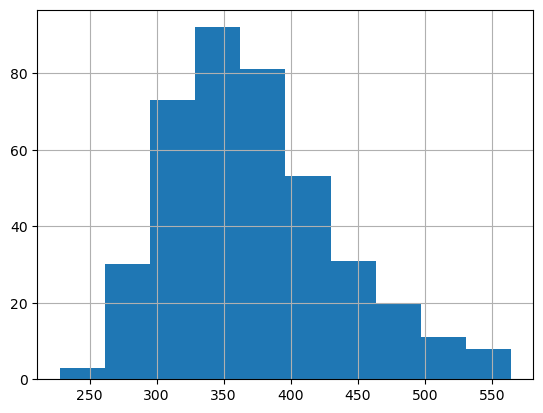

In [28]:
prompt_tokens.hist()

<Axes: >

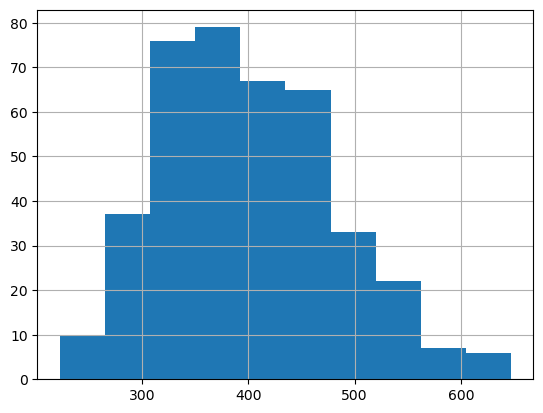

In [29]:
completion_tokens.hist()

In [30]:
print(f'''
Max amount of tokens:

    Prompts: {prompt_tokens.max()}
    Completions: {completion_tokens.max()}
''')


Max amount of tokens:

    Prompts: 564
    Completions: 647

